<a href="https://colab.research.google.com/github/eshal26/Leukemia-classification/blob/main/GoogleNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip Original.zip

Archive:  Original.zip
   creating: Original/Benign/
  inflating: Original/Benign/WBC-Benign-001.jpg  
  inflating: Original/Benign/WBC-Benign-002.jpg  
  inflating: Original/Benign/WBC-Benign-003.jpg  
  inflating: Original/Benign/WBC-Benign-004.jpg  
  inflating: Original/Benign/WBC-Benign-005.jpg  
  inflating: Original/Benign/WBC-Benign-006.jpg  
  inflating: Original/Benign/WBC-Benign-007.jpg  
  inflating: Original/Benign/WBC-Benign-008.jpg  
  inflating: Original/Benign/WBC-Benign-009.jpg  
  inflating: Original/Benign/WBC-Benign-010.jpg  
  inflating: Original/Benign/WBC-Benign-011.jpg  
  inflating: Original/Benign/WBC-Benign-012.jpg  
  inflating: Original/Benign/WBC-Benign-013.jpg  
  inflating: Original/Benign/WBC-Benign-014.jpg  
  inflating: Original/Benign/WBC-Benign-015.jpg  
  inflating: Original/Benign/WBC-Benign-016.jpg  
  inflating: Original/Benign/WBC-Benign-017.jpg  
  inflating: Original/Benign/WBC-Benign-018.jpg  
  inflating: Original/Benign/WBC-Benign-019.jpg

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
import sklearn
from sklearn.model_selection import train_test_split

In [ ]:
import shutil

# Define paths to your dataset directories
dataset_dir = 'Original'
benign_dir = os.path.join(dataset_dir, 'Benign')
malignant_dir = os.path.join(dataset_dir, 'Malignant')  # Create this directory if it doesn't exist

# Create the malignant directory if it doesn't exist
if not os.path.exists(malignant_dir):
    os.makedirs(malignant_dir)

# Move images from early, pre, and pro directories to malignant directory
for stage in ['Early', 'Pre', 'Pro']:
    stage_dir = os.path.join(dataset_dir, stage)
    for img_file in os.listdir(stage_dir):
        img_path = os.path.join(stage_dir, img_file)
        shutil.move(img_path, malignant_dir)

# Update dataset directory structure and labels
os.rmdir(os.path.join(dataset_dir, 'Early'))
os.rmdir(os.path.join(dataset_dir, 'Pre'))
os.rmdir(os.path.join(dataset_dir, 'Pro'))

In [15]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths to your original dataset directory
original_data_dir = 'Original'
benign_dir = os.path.join(original_data_dir, 'Benign')
malignant_dir = os.path.join(original_data_dir, 'Malignant')

# Define paths to create directories for the new dataset splits
train_dir = 'train_dataset'
val_dir = 'validation_dataset'
test_dir = 'test_dataset'

# Create directories for the new dataset splits if they don't exist
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)
    for category in ['Benign', 'Malignant']:
        os.makedirs(os.path.join(directory, category), exist_ok=True)

# Split dataset and copy images to appropriate directories
for category_dir, category in [(benign_dir, 'Benign'), (malignant_dir, 'Malignant')]:
    image_files = [os.path.join(category_dir, img) for img in os.listdir(category_dir)]
    train_files, test_val_files = train_test_split(image_files, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

    for file in train_files:
        shutil.copy(file, os.path.join(train_dir, category))
    for file in val_files:
        shutil.copy(file, os.path.join(val_dir, category))
    for file in test_files:
        shutil.copy(file, os.path.join(test_dir, category))

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(320),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [16]:
data_dir = {
    'train': 'train_dataset',
    'val': 'validation_dataset',
    'test': 'test_dataset'
}

image_datasets = {x: datasets.ImageFolder(data_dir[x], data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes


In [22]:
model_ft = models.inception_v3(pretrained=True)

# Freeze the layers of the model
for param in model_ft.parameters():
    param.requires_grad = False

# Modify the final layer and the auxiliary layer for binary classification
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 1)


num_ftrs_aux = model_ft.AuxLogits.fc.in_features
model_ft.AuxLogits.fc = nn.Linear(num_ftrs_aux, 1)  # Auxiliary output layer for binary classification

# Set device to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model_ft = model_ft.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_ft.fc.parameters(), lr=0.001, weight_decay=0.0001)


In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Training function
def train_model(model, criterion, optimizer,  train_loader, val_loader, num_epochs=10):
    train_acc_history = []
    val_acc_history = []
    train_precision_history = []
    val_precision_history = []
    train_recall_history = []
    val_recall_history = []
    train_f1_history = []
    val_f1_history = []

    dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_labels = []
            all_preds = []

            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device).float()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        outputs = outputs.squeeze()
                        aux_outputs = aux_outputs.squeeze()
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        outputs = outputs.squeeze()
                        loss = criterion(outputs, labels)

                    preds = torch.sigmoid(outputs) > 0.5
                    all_labels.extend(labels.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            precision = precision_score(all_labels, all_preds, average='binary')
            recall = recall_score(all_labels, all_preds, average='binary')
            f1 = f1_score(all_labels, all_preds, average='binary')

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_precision_history.append(precision)
                train_recall_history.append(recall)
                train_f1_history.append(f1)
            else:
                val_acc_history.append(epoch_acc)
                val_precision_history.append(precision)
                val_recall_history.append(recall)
                val_f1_history.append(f1)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {precision:.4f} Recall: {recall:.4f} F1-score: {f1:.4f}')

    return model, train_acc_history, val_acc_history, train_precision_history, val_precision_history, train_recall_history, val_recall_history, train_f1_history, val_f1_history

# Train the model
model_ft, train_acc_history, val_acc_history, train_precision_history, val_precision_history, train_recall_history, val_recall_history, train_f1_history, val_f1_history = train_model(model_ft, criterion, optimizer, dataloaders['train'], dataloaders['val'], num_epochs=20)


Epoch 0/19
----------
train Loss: 0.6120 Acc: 0.8664 Precision: 0.8649 Recall: 0.9977 F1-score: 0.9266
val Loss: 0.2664 Acc: 0.8677 Precision: 0.8648 Recall: 1.0000 F1-score: 0.9275
Epoch 1/19
----------
train Loss: 0.5659 Acc: 0.8909 Precision: 0.8907 Recall: 0.9927 F1-score: 0.9390
val Loss: 0.2310 Acc: 0.8862 Precision: 0.8814 Recall: 1.0000 F1-score: 0.9370
Epoch 2/19
----------
train Loss: 0.5392 Acc: 0.9071 Precision: 0.9107 Recall: 0.9868 F1-score: 0.9472
val Loss: 0.2072 Acc: 0.9477 Precision: 0.9479 Recall: 0.9927 F1-score: 0.9698
Epoch 3/19
----------
train Loss: 0.5160 Acc: 0.9167 Precision: 0.9218 Recall: 0.9850 F1-score: 0.9523
val Loss: 0.1812 Acc: 0.9323 Precision: 0.9259 Recall: 1.0000 F1-score: 0.9615
Epoch 4/19
----------
train Loss: 0.5065 Acc: 0.9228 Precision: 0.9277 Recall: 0.9855 F1-score: 0.9557
val Loss: 0.1636 Acc: 0.9415 Precision: 0.9384 Recall: 0.9964 F1-score: 0.9665
Epoch 5/19
----------
train Loss: 0.4886 Acc: 0.9313 Precision: 0.9362 Recall: 0.9859 F1-s

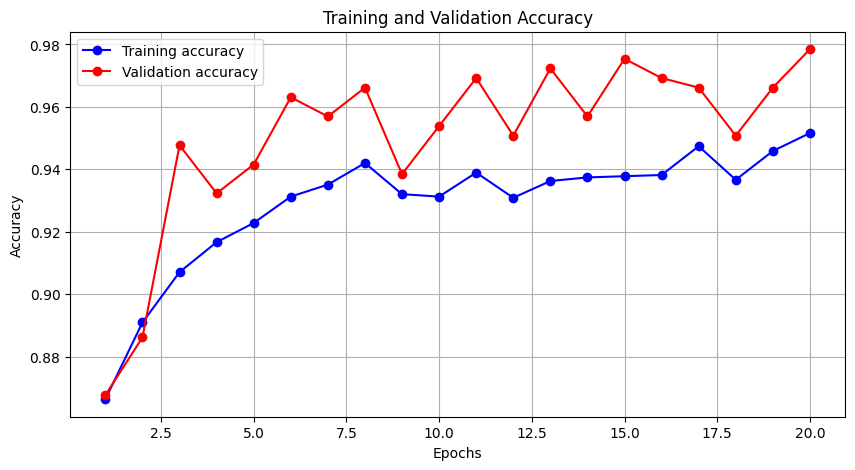

In [27]:

import matplotlib.pyplot as plt

def plot_training_results(train_acc_history, val_acc_history):
    train_acc_history = [x.cpu().numpy() for x in train_acc_history]
    val_acc_history = [x.cpu().numpy() for x in val_acc_history]

    epochs = range(1, len(train_acc_history) + 1)

    plt.figure(figsize=(10, 5))

    # Plot training and validation accuracy
    plt.plot(epochs, train_acc_history, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc_history, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

# Assuming train_acc_history and val_acc_history are already defined
plot_training_results(train_acc_history, val_acc_history)


Test Loss: 0.0984
Test Accuracy: 0.9725
Test Precision: 0.9721
Test Recall: 0.9725
Test F1-score: 0.9721
Confusion Matrix:
 [[ 45   6]
 [  3 273]]


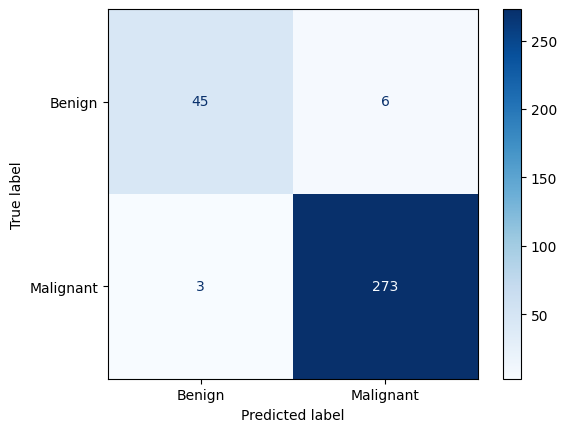

Classification Report:
               precision    recall  f1-score   support

      Benign       0.94      0.88      0.91        51
   Malignant       0.98      0.99      0.98       276

    accuracy                           0.97       327
   macro avg       0.96      0.94      0.95       327
weighted avg       0.97      0.97      0.97       327



In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model_with_detailed_metrics(model, dataloader, criterion, device):
    model.eval()
    test_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Apply sigmoid function and threshold to get binary predictions
            outputs = outputs.squeeze()  # Remove extra dimension for binary classification
            preds = torch.sigmoid(outputs) > 0.5  # Convert to binary predictions

            # Convert predictions and labels to numpy for metrics calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Compute loss
            loss = criterion(outputs, labels.float())
            test_loss += loss.item() * inputs.size(0)

    test_loss /= len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-score: {f1:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Print classification report
    class_report = classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant'])
    print("Classification Report:\n", class_report)

    return test_loss, accuracy, precision, recall, f1, cm, class_report

# Example usage
test_loss, test_accuracy, test_precision, test_recall, test_f1, cm, class_report = evaluate_model_with_detailed_metrics(model_ft, dataloaders['test'], criterion, device)
